# Asyncronous Read from the Geiger counter

## Requirenments packages
### Please Install those packages before proceeding
matplotlib==3.5.2 <br>
numpy==1.22.4 <br>
pandas==1.4.2 <br>
aioserial==1.3.0

In [1]:
from matplotlib import pyplot as plt
from IPython import display
import aioserial as serial
import pandas as pd
import numpy as np
import time
import asyncio
import datetime

In [2]:
async def read(port):
    """
    Asyncronous read from usb port
    Arguments:
        port: Absolute path to usb port
    Returns:
        Yields integers the values it got from usb port
    """
    with serial.AioSerial(port) as ser:
        while True:
            s = await ser.read_async(4)
            time=int.from_bytes(s, "little") 
            yield time
            
def execute(port,parser):
    """
    Runs asyncronous code in the background
    Arguments:
        port: Absolute path to usb port
        parser: Asyncronous parser for the date
    """
    global read
    asyncio.create_task(parser(read(port)))

#### And it's Parser

In [3]:
if('Time' not in globals()):
 Time = []

async def parser(read):
    """
    Asyncronously parses the read sygnal
    Arguments:
        read: The reading from the read function
    """
    async for time in read:
        # please define custom parser here
        Time.append(time)
    
    
# in order to execute the parser above use execute function
port = "/dev/tty.usbmodem112301" # <----- change this to your correct value
execute(port, parser)
    

# or let the python handle it for you
dev = !ls /dev/
for usb in [path for path in dev if 'usb' in path and 'tty' in path ]:
    print(f"Executing on port: /dev/{usb}")
    execute(f"/dev/{usb}",parser)

Executing on port: /dev/tty.usbmodem112301


### At this point, the list "Time" is updated in real time, Try running the below code several times to get the output

In [4]:
Time

[]

# Plotting in real time

In [5]:
def cps(Raw,seconds = 1):
    """
    Return average cps 
    Arguments:
        Raw: Get the raw Time series data
        seconds: number of seconds the average needed to be taken
    Returns:
        Return the cps on every next data
    """
    T = np.round(Raw//1000000,3)
    CPS = []
    for t in T:
        CPS.append(len(T[(t < T) & (T < t+seconds)]))
        if(max(T) < t+seconds):
            break
    return np.array(CPS)

def Plot(Times,legends=None):
    """
    Plots 5 plots
    Arguments:
        Times: Get the raw Time series data
    """
    fig, [wt,wt_pdf,wt_cdf,cpm,cp5m] = plt.subplots(5,figsize=(16,30))    
    Times = [np.sort(Time) for Time in Times]
    
    
    wt.title.set_text('Waiting Time')        
    wt_pdf.title.set_text('Waiting Time PDF')    
    cpm.title.set_text('CPM')
    cp5m.title.set_text('CPM(5 Minutes)')
    wt_cdf.title.set_text('Waiting Time CDF')

    wt_cdf.set_yscale('log')
    wt_pdf.set_yscale('log')
    
    wt.set_xlabel('Next hit')
    wt.set_ylabel('seconds')
    wt_cdf.set_xlabel('seconds')
    wt_cdf.set_ylabel('proportion')
    wt_pdf.set_xlabel('seconds')
    wt_pdf.set_ylabel('proportion')
    cpm.set_xlabel('seconds')
    cpm.set_ylabel('CPM')
    cp5m.set_xlabel('seconds')
    cp5m.set_ylabel('CPM')
    
    Tdiffs = [ np.diff(Time,1)/1000000 for Time in Times]
    
    # Waiting Time plot
    for Tdiff in Tdiffs:
        wt.plot(Tdiff)
        
    # Waiting Time PDF plot
    wt_pdf.hist(Tdiffs, bins=np.linspace(0,10,10),
                 weights =  [[1/len(Tdiff)]*len(Tdiff) for Tdiff in Tdiffs])

    # Waiting Time CDF Plot
    for Tdiff in Tdiffs:
        wt_cdf.plot(np.sort(Tdiff),1-np.arange(len(Tdiff))/len(Tdiff), '.-')

    # CPM and CP5M plot
    for Time in Times:
        cpm.plot(cps(Time,seconds = 60))
        cp5m.plot(cps(Time,seconds = 300)/5)


    # Apply Legends
    if(legends is not None):
        wt.legend(legends)      
        wt_pdf.legend(legends)   
        cpm.legend(legends)
        cp5m.legend(legends)
        wt_cdf.legend(legends)

    # Return These Values in a Table
    Table = {}
    Table['count'] = [len(Time) for Time in Times]
    Table['time'] = [str(datetime.timedelta(seconds = int(Time[-1]-Time[0])//1000000)) for Time in Times]
    Table['cpm'] = [np.average(cps(Time,seconds=60)) for Time in Times]
    Table['cpm+-']=[]
    Table['cpm+-(5m)'] = []
    for Time in Times:
        cpm = cps(Time,seconds=60)
        cp5m = cps(Time,seconds=300)/5
        Table['cpm+-'].append(np.std(cpm,ddof=1) if len(cpm)!=1 else None)
        Table['cpm+-(5m)'].append(np.std(cp5m,ddof=1) if len(cp5m)!=1 else None)
    return pd.DataFrame.from_dict(Table,orient='index',columns=legends)
    

,Background,Lead,Cobalt
count,243,362,1163
time,0:12:24,0:05:41,0:11:10
cpm,19.377778,63.232323,101.662617
cpm+-,5.831292,6.538599,8.422497
cpm+-(5m),3.118236,0.980091,1.866931


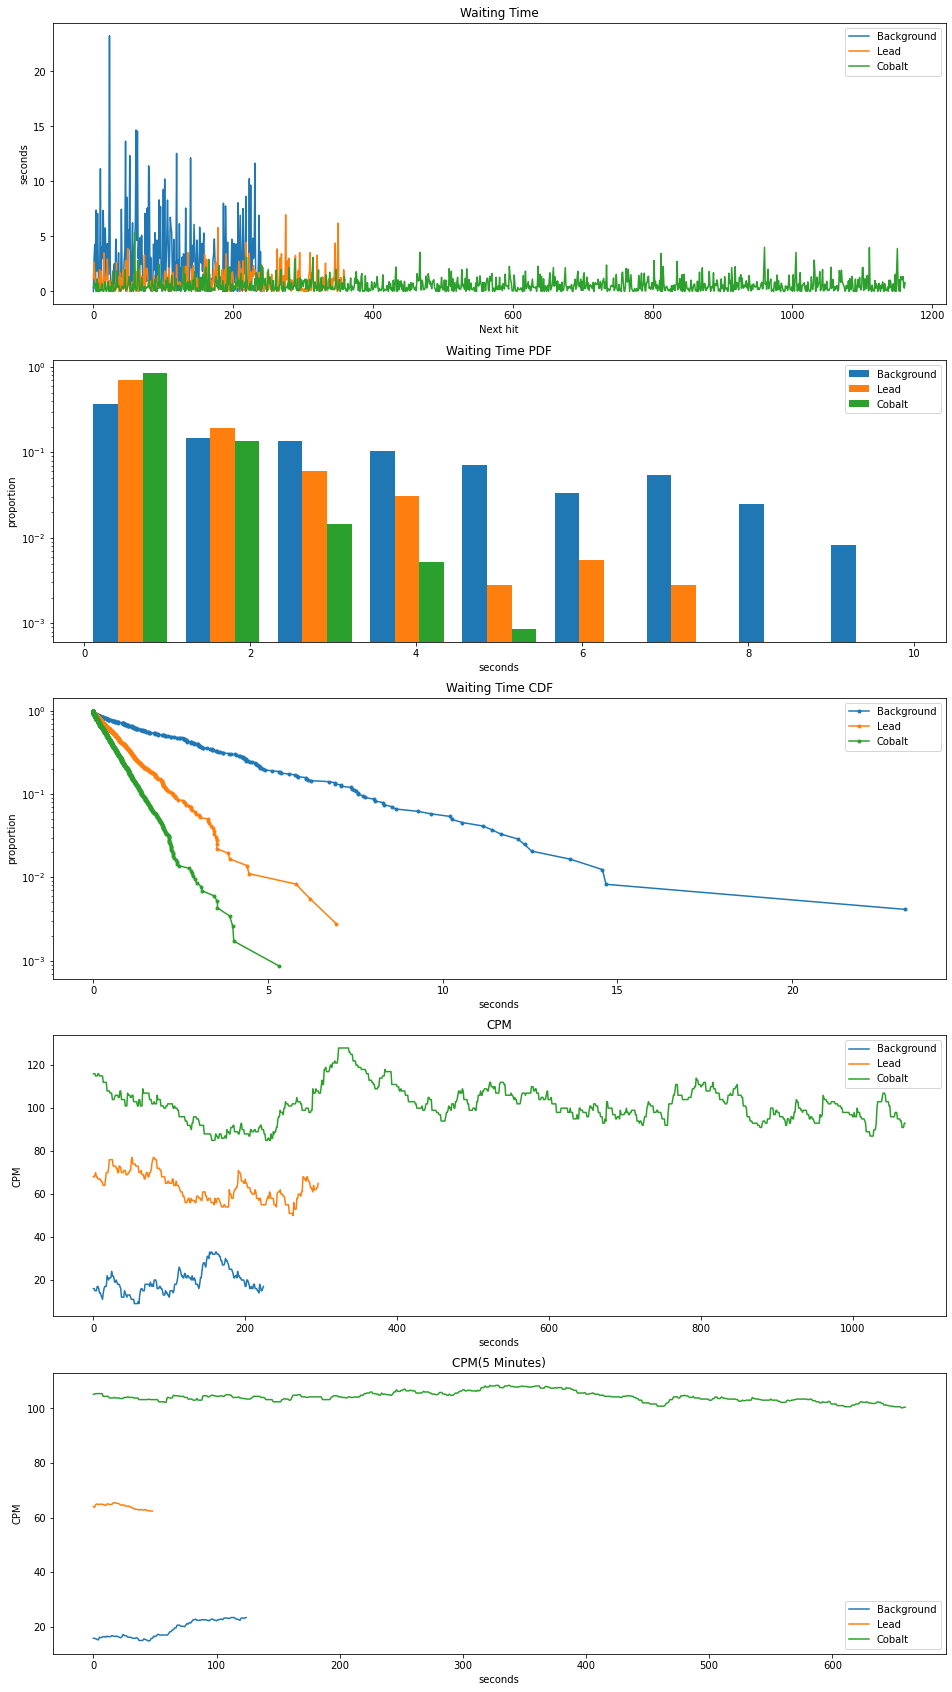

In [6]:
# Load the data from saved values, if you have some and plot them

Background = np.loadtxt('background.npy')
Cobalt = np.loadtxt('Cobaltik.npy')
Lead = np.loadtxt('Kaparik.npy')


Plot([Background,Lead,Cobalt],
    ('Background','Lead','Cobalt'))

### In real Time Plot

Sidenote: In order to close the plot, you need to stop the jupyter-notebook server. <br/> 
DO NOT RESTART THE SERVER, BECAUSE IT WILL DELETE "Time" VARIABLE <br/>
Instead, stop the execution of the current plot by pressing Esc+I+I, or press the stop button in the headers

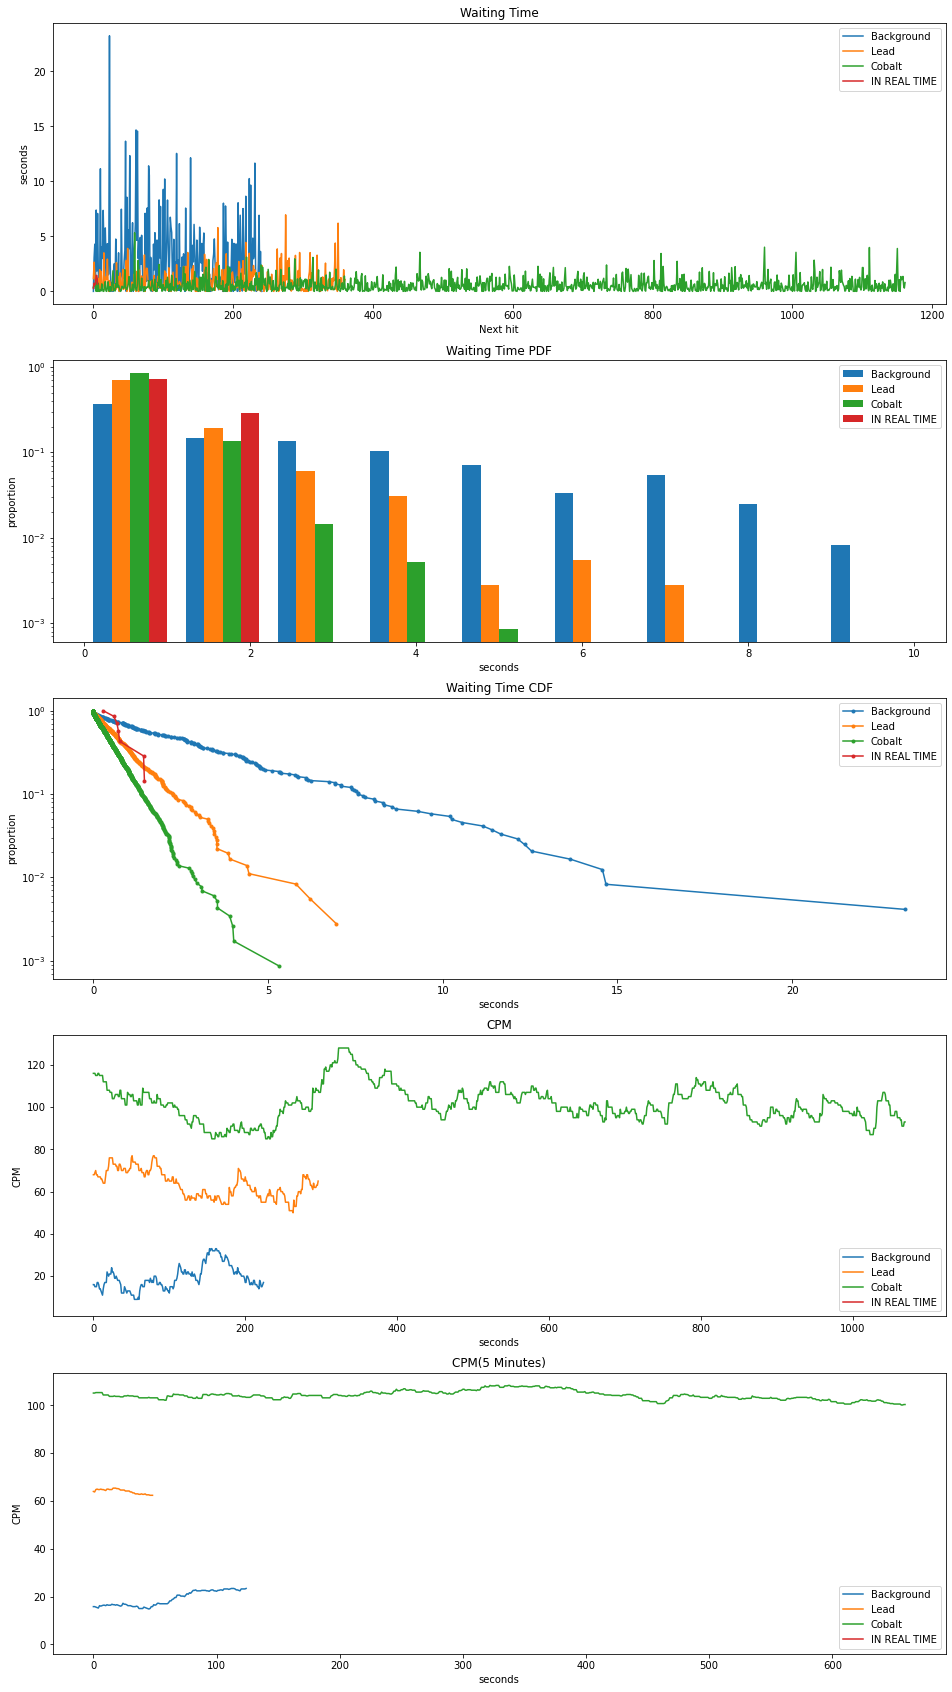

,Background,Lead,Cobalt,IN REAL TIME
count,243,362,1163,8
time,0:12:24,0:05:41,0:11:10,0:00:05
cpm,19.377778,63.232323,101.662617,7.0
cpm+-,5.831292,6.538599,8.422497,None
cpm+-(5m),3.118236,0.980091,1.866931,None


In [ ]:
from asyncio import CancelledError
%matplotlib inline
try:  
 while True:
    await asyncio.sleep(1)
    if(len(Time)>=2):
        
        Df = Plot([Background,Lead,Cobalt,Time], ('Background','Lead','Cobalt', "IN REAL TIME"))
        
        # Use this if you don't have data
        #Df = Plot([Time],["In real Time"])
        
        
        display.display(plt.gcf())
        display.display(Df)
        display.clear_output(wait=True)        
        
except CancelledError:
    plt.close('all')
    display.clear_output(wait=True) 

In [ ]:
# save values to have something plot against
np.savetxt("custom_name.npy",Time)